In [33]:
from pathlib import Path
import calendar

#for data manipulation
import numpy as np
import pandas as pd

#for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#for modeling
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance 

#for metrics and other functions
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve

#for saving models
import pickle 


In [34]:
#load dataset into frame
lon_wr = Path("C:/Users/Phill/OneDrive/Documents/Python Scripts/london/london_weather.csv")
df = pd.read_csv(lon_wr.resolve(), sep=',')
df.head()

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,19790103,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,19790104,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,19790105,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0


## Gather Insights About the Data

In [35]:
#Get Info
print(df.info())
print(" ")
print(df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15341 entries, 0 to 15340
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              15341 non-null  int64  
 1   cloud_cover       15322 non-null  float64
 2   sunshine          15341 non-null  float64
 3   global_radiation  15322 non-null  float64
 4   max_temp          15335 non-null  float64
 5   mean_temp         15305 non-null  float64
 6   min_temp          15339 non-null  float64
 7   precipitation     15335 non-null  float64
 8   pressure          15337 non-null  float64
 9   snow_depth        13900 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 1.2 MB
None
 
Index(['date', 'cloud_cover', 'sunshine', 'global_radiation', 'max_temp',
       'mean_temp', 'min_temp', 'precipitation', 'pressure', 'snow_depth'],
      dtype='object')


Upon review, all but the date column are float data types. We also find that all but the date and sunshine column are missing some values that will need to addressed; snow_depth especially. 

In [36]:
#renaming columns for clarity and use
df = df.rename(columns={'sunshine': 'sun_hrs',
                        'global_radiation': 'radiation',
                        'precipitation': 'rainfall'})

df.head(-10)

,date,cloud_cover,sun_hrs,radiation,max_temp,mean_temp,min_temp,rainfall,pressure,snow_depth
0,19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,19790103,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,19790104,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,19790105,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0
...,...,...,...,...,...,...,...,...,...,...
15326,20201217,3.0,1.1,25.0,11.6,8.9,6.2,0.0,101320.0,NaN
15327,20201218,8.0,4.4,38.0,11.6,10.3,9.0,1.8,101130.0,NaN
15328,20201219,3.0,0.5,15.0,12.5,11.2,9.9,9.0,100450.0,NaN
15329,20201220,1.0,3.3,37.0,10.6,8.6,6.7,0.6,101170.0,NaN


In [37]:
#Check for Duplicates
df.duplicated().sum()

0

In [38]:
#Get a general description
df.describe()

,date,cloud_cover,sun_hrs,radiation,max_temp,mean_temp,min_temp,rainfall,pressure,snow_depth
count,1.534100e+04,15322.000000,15341.000000,15322.000000,15335.000000,15305.000000,15339.000000,15335.000000,15337.000000,13900.000000
mean,1.999567e+07,5.268242,4.350238,118.756951,15.388777,11.475511,7.559867,1.668634,101536.605594,0.037986
std,1.212176e+05,2.070072,4.028339,88.898272,6.554754,5.729709,5.326756,3.738540,1049.722604,0.545633
min,1.979010e+07,0.000000,0.000000,8.000000,-6.200000,-7.600000,-11.800000,0.000000,95960.000000,0.000000
25%,1.989070e+07,4.000000,0.500000,41.000000,10.500000,7.000000,3.500000,0.000000,100920.000000,0.000000
50%,2.000010e+07,6.000000,3.500000,95.000000,15.000000,11.400000,7.800000,0.000000,101620.000000,0.000000
75%,2.010070e+07,7.000000,7.200000,186.000000,20.300000,16.000000,11.800000,1.600000,102240.000000,0.000000
max,2.020123e+07,9.000000,16.000000,402.000000,37.900000,29.000000,22.300000,61.800000,104820.000000,22.000000


After reviewing this table, there does not appear to be any major concerns when it comes to wrong entries or extreme values. 

In [39]:
#check for missing values
df.isna().sum()

date              0
cloud_cover      19
sun_hrs           0
radiation        19
max_temp          6
mean_temp        36
min_temp          2
rainfall          6
pressure          4
snow_depth     1441
dtype: int64

The missing values of snow_depth does cause some concern. After reviewing the first five and last entries of the dataset we see that snow_depth can be zero, indicating that it was not recorded. This concern is backed by the fact that December dates are missing these values, which are clearly times that are likely to see snowfall. 

Given the small amounts of entries missing from other features, there does not seem to be much concern of correlation in these omissions. Nonetheless, we will review it. 

Percent of Entries Missing Snow Data: 9.393129522195425 %


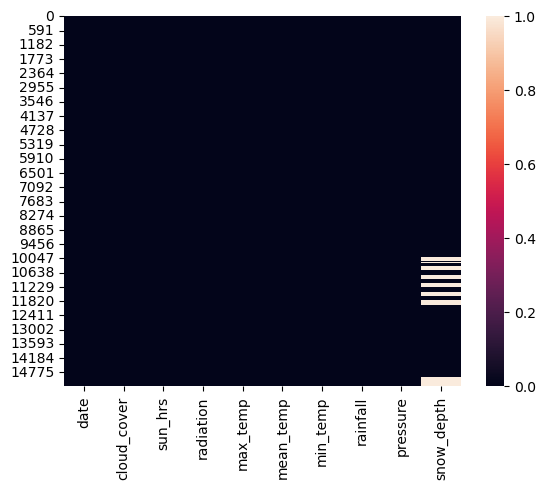

In [40]:
#checking the distribution of missing values 
sns.heatmap(df.isnull())
print('Percent of Entries Missing Snow Data:', (df['snow_depth'].isna().sum()/len(df))*100, '%')

There appears to be time periods that are missing data relating to snow_depth. The rows missing this data account for 9.39% of entries. We will need to look into this feature a little more before deciding what to do about it. 

In [41]:
#explore use of snow_depth
print((df['snow_depth'] > 0).sum()/len(df['snow_depth']))
print((df['snow_depth'] > 0).sum(), 'days out of', (len(df['snow_depth'])))

0.009125871846685353
140 days out of 15341


It is very clear that snow is a rarity in London, accounting for less than 1% of the recorded days over 42 years. In other words, 140 days out of 15341. Essentially, its values are heavily unbalanced and it is very unlikely to be a good indicator of anything by itself. 

- The snow_depth column is either zero or null, 99.1% of the time, so we will remove this column entirely.

In [42]:
df1 = df.copy()
df1 = df1.drop('snow_depth', axis=1)
df1.head()

,date,cloud_cover,sun_hrs,radiation,max_temp,mean_temp,min_temp,rainfall,pressure
0,19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0
1,19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0
2,19790103,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0
3,19790104,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0
4,19790105,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0


In [43]:
#create month column for encoding
df1['date'] = pd.to_datetime(df1['date'], format='%Y%m%d')
df1['month'] = pd.to_datetime(df1['date']).dt.month.astype(str)

months = {'1': 'Jan', '2': 'Feb', '3': 'Mar', '4': 'Apr', '5': 'May', '6': 'Jun', '7': 'Jul', '8': 'Aug', '9': 'Sep', '10': 'Oct', '11': 'Nov', '12': 'Dec'}

df1['month'] = df1['month'].map(months)

df1.head(-10)

,date,cloud_cover,sun_hrs,radiation,max_temp,mean_temp,min_temp,rainfall,pressure,month
0,1979-01-01,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,Jan
1,1979-01-02,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,Jan
2,1979-01-03,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,Jan
3,1979-01-04,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,Jan
4,1979-01-05,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,Jan
...,...,...,...,...,...,...,...,...,...,...
15326,2020-12-17,3.0,1.1,25.0,11.6,8.9,6.2,0.0,101320.0,Dec
15327,2020-12-18,8.0,4.4,38.0,11.6,10.3,9.0,1.8,101130.0,Dec
15328,2020-12-19,3.0,0.5,15.0,12.5,11.2,9.9,9.0,100450.0,Dec
15329,2020-12-20,1.0,3.3,37.0,10.6,8.6,6.7,0.6,101170.0,Dec


In [44]:
#Check df for outliers
def check_outliers(column):
    percentile25 = column.quantile(0.25)
    percentile75 = column.quantile(0.75)
    
    iqr = percentile75 - percentile25
    
    upper_limit = percentile75 + 1.5 * iqr
    lower_limit = percentile25 - 1.5 * iqr

    outliers = df1[(column > upper_limit) | (column < lower_limit)]
     
    return len(outliers)

In [45]:
print('cloud_cover outliers:', check_outliers(df1['cloud_cover']))
print('sun_hrs outliers:', check_outliers(df1['sun_hrs']))
print('radiation outliers:', check_outliers(df1['radiation']))
print('max_temp outliers:', check_outliers(df1['max_temp']))
print('mean_temp outliers:', check_outliers(df1['mean_temp']))
print('min_temp outliers:', check_outliers(df1['min_temp']))
print('pressure outliers:', check_outliers(df1['pressure']))

cloud_cover outliers: 0
sun_hrs outliers: 0
radiation outliers: 0
max_temp outliers: 11
mean_temp outliers: 1
min_temp outliers: 5
pressure outliers: 243


- Given our choice of tree based models, outliers are not too much of a concern unless they are wrong entries.
- As for the missing values, they can only account for 0.6% of entries max, thus we will remove them. 

In [46]:
#remove rows with any missing entries
df1 = df1.dropna(axis=0)

In [47]:
#check percentage of days that had rainfall 
print((df1['rainfall'] > 0).sum()/len(df1['rainfall']))

0.48122665618242577


This ratio confirms that, yes, London is indeed a rainy city! This also means that it will be safe to convert rainfall to a binary variable without any resampling, indicating if a day rainfall or not. 

In [48]:
#create binary rainfall column for the outcome variable to replace rainfall column 
df1['b_rain'] = np.where(df1['rainfall'] > 0, 1, 0)
df1 = df1.drop('rainfall', axis=1)
df1.head(-10)

,date,cloud_cover,sun_hrs,radiation,max_temp,mean_temp,min_temp,pressure,month,b_rain
0,1979-01-01,2.0,7.0,52.0,2.3,-4.1,-7.5,101900.0,Jan,1
1,1979-01-02,6.0,1.7,27.0,1.6,-2.6,-7.5,102530.0,Jan,0
2,1979-01-03,5.0,0.0,13.0,1.3,-2.8,-7.2,102050.0,Jan,0
3,1979-01-04,8.0,0.0,13.0,-0.3,-2.6,-6.5,100840.0,Jan,0
4,1979-01-05,6.0,2.0,29.0,5.6,-0.8,-1.4,102250.0,Jan,0
...,...,...,...,...,...,...,...,...,...,...
15325,2020-12-16,7.0,3.1,36.0,10.6,8.6,6.6,100710.0,Dec,1
15326,2020-12-17,3.0,1.1,25.0,11.6,8.9,6.2,101320.0,Dec,0
15327,2020-12-18,8.0,4.4,38.0,11.6,10.3,9.0,101130.0,Dec,1
15328,2020-12-19,3.0,0.5,15.0,12.5,11.2,9.9,100450.0,Dec,1


In [49]:
#remove the date column as we will rely on the created month column for time correlation 
df3 = df1.copy()
df3 = df3.drop('date', axis=1)
df3.head(-10)

,cloud_cover,sun_hrs,radiation,max_temp,mean_temp,min_temp,pressure,month,b_rain
0,2.0,7.0,52.0,2.3,-4.1,-7.5,101900.0,Jan,1
1,6.0,1.7,27.0,1.6,-2.6,-7.5,102530.0,Jan,0
2,5.0,0.0,13.0,1.3,-2.8,-7.2,102050.0,Jan,0
3,8.0,0.0,13.0,-0.3,-2.6,-6.5,100840.0,Jan,0
4,6.0,2.0,29.0,5.6,-0.8,-1.4,102250.0,Jan,0
...,...,...,...,...,...,...,...,...,...
15325,7.0,3.1,36.0,10.6,8.6,6.6,100710.0,Dec,1
15326,3.0,1.1,25.0,11.6,8.9,6.2,101320.0,Dec,0
15327,8.0,4.4,38.0,11.6,10.3,9.0,101130.0,Dec,1
15328,3.0,0.5,15.0,12.5,11.2,9.9,100450.0,Dec,1


The dataset is now cleaned and ready for EDA. 

In [18]:
#Save Cleaned CSV for Visualization and Reference 
df1.to_csv('london_clean.csv', index=False)

# Exploratory Data Analysis

In [50]:
#correlate data for visual
df_c = df3.copy()
df_c = df_c.drop('month', axis=1)
df_c.corr(method='pearson')

,cloud_cover,sun_hrs,radiation,max_temp,mean_temp,min_temp,pressure,b_rain
cloud_cover,1.000000,-0.737669,-0.485065,-0.209624,-0.108201,0.051675,-0.241968,0.333728
sun_hrs,-0.737669,1.000000,0.852752,0.469546,0.393780,0.215738,0.227603,-0.375314
radiation,-0.485065,0.852752,1.000000,0.690547,0.634943,0.477055,0.151260,-0.299859
max_temp,-0.209624,0.469546,0.690547,1.000000,0.911944,0.809902,0.101335,-0.195366
mean_temp,-0.108201,0.393780,0.634943,0.911944,1.000000,0.955545,0.005535,-0.118982
min_temp,0.051675,0.215738,0.477055,0.809902,0.955545,1.000000,-0.073776,-0.045803
pressure,-0.241968,0.227603,0.151260,0.101335,0.005535,-0.073776,1.000000,-0.448376
b_rain,0.333728,-0.375314,-0.299859,-0.195366,-0.118982,-0.045803,-0.448376,1.000000


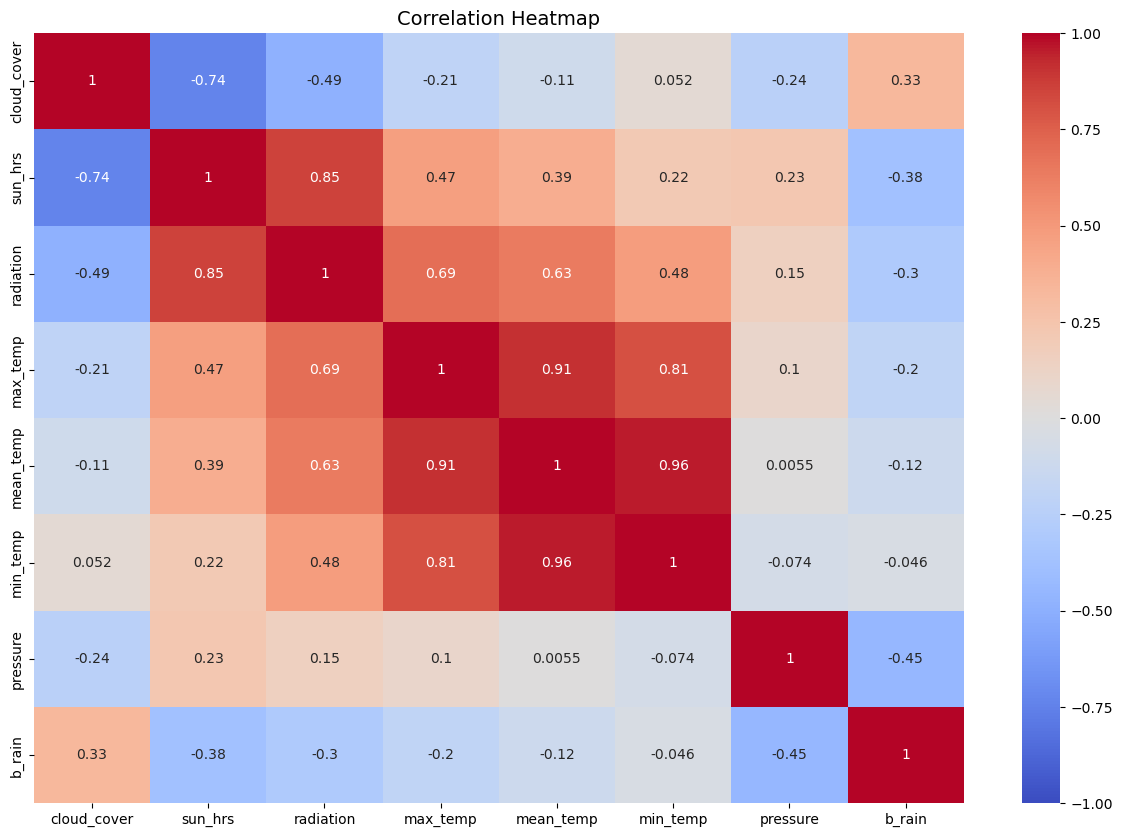

In [51]:
#Create a correlation heatmap
plt.figure(figsize=(15,10))
sns.heatmap(df_c.corr(method='pearson'), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap', fontsize =14)
plt.show();

Though feature correlation is not something we need to correct for tree-based models, it does provide good insights. Looking at this heatmap, there is a fair bit of colinearity between certain features that seem to make sense, like sun_hrs and radiation at 85% and all temp related features at or above 81%. We also find a few suggestive negative correlations like pressure and rain, sun_hrs and cloud_over, as well as radiation and cloud_cover. At this stage it seems that pressure, sun_hrs, and cloud_cover could be important features within the models.   

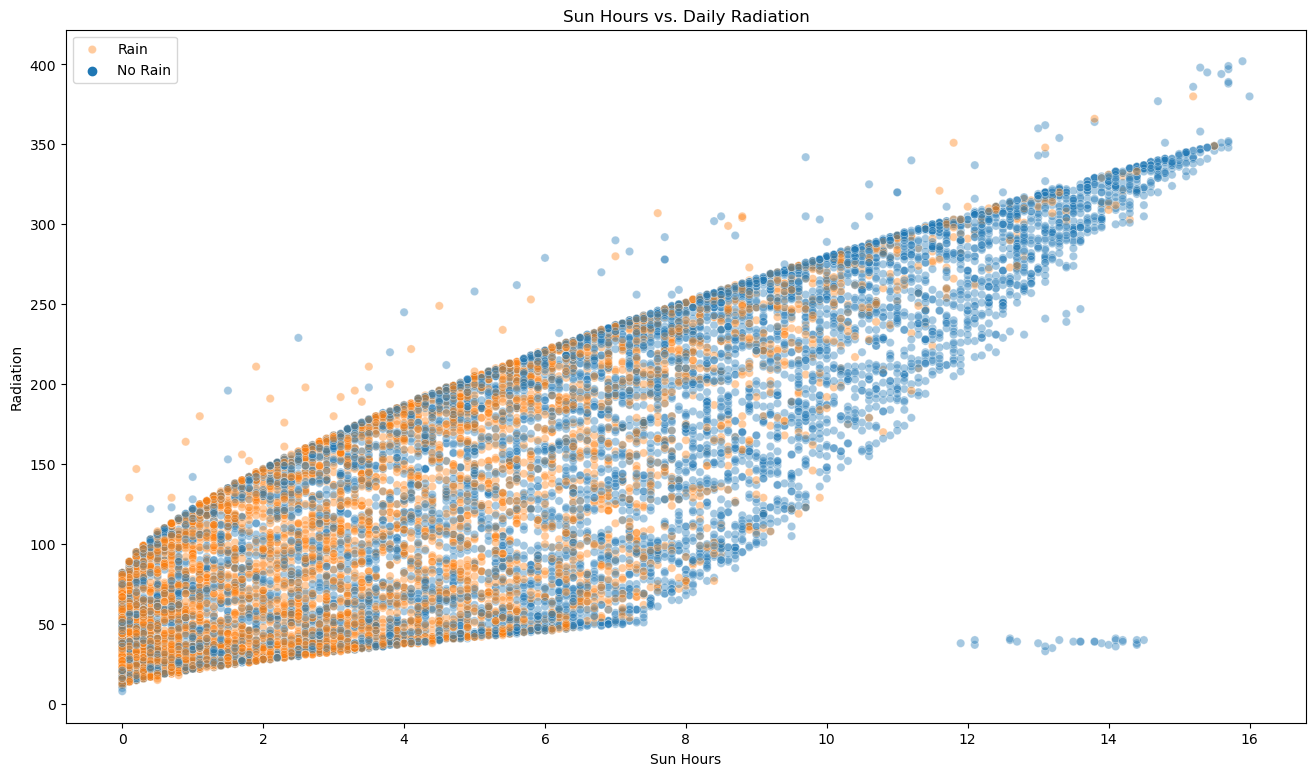

In [52]:
#create a scatterplot to a get a visual representation of these relationships

plt.figure(figsize=(16,9))
sns.scatterplot(data=df3, x='sun_hrs', y='radiation', hue='b_rain', alpha=0.4)
plt.legend(labels=['Rain', 'No Rain'])
plt.title('Sun Hours vs. Daily Radiation')
plt.xlabel('Sun Hours')
plt.ylabel('Radiation')
plt.show();

While there is a fair spread of days with and without rain when it is sunnier, a large portion of rainy days occur when there is little sun hours and subsequently lower radiation. The correlation map above confirms this. 

C:\Users\Phill\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Phill\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Phill\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Phill\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length

Text(0.5, 1.0, 'Max Temp')

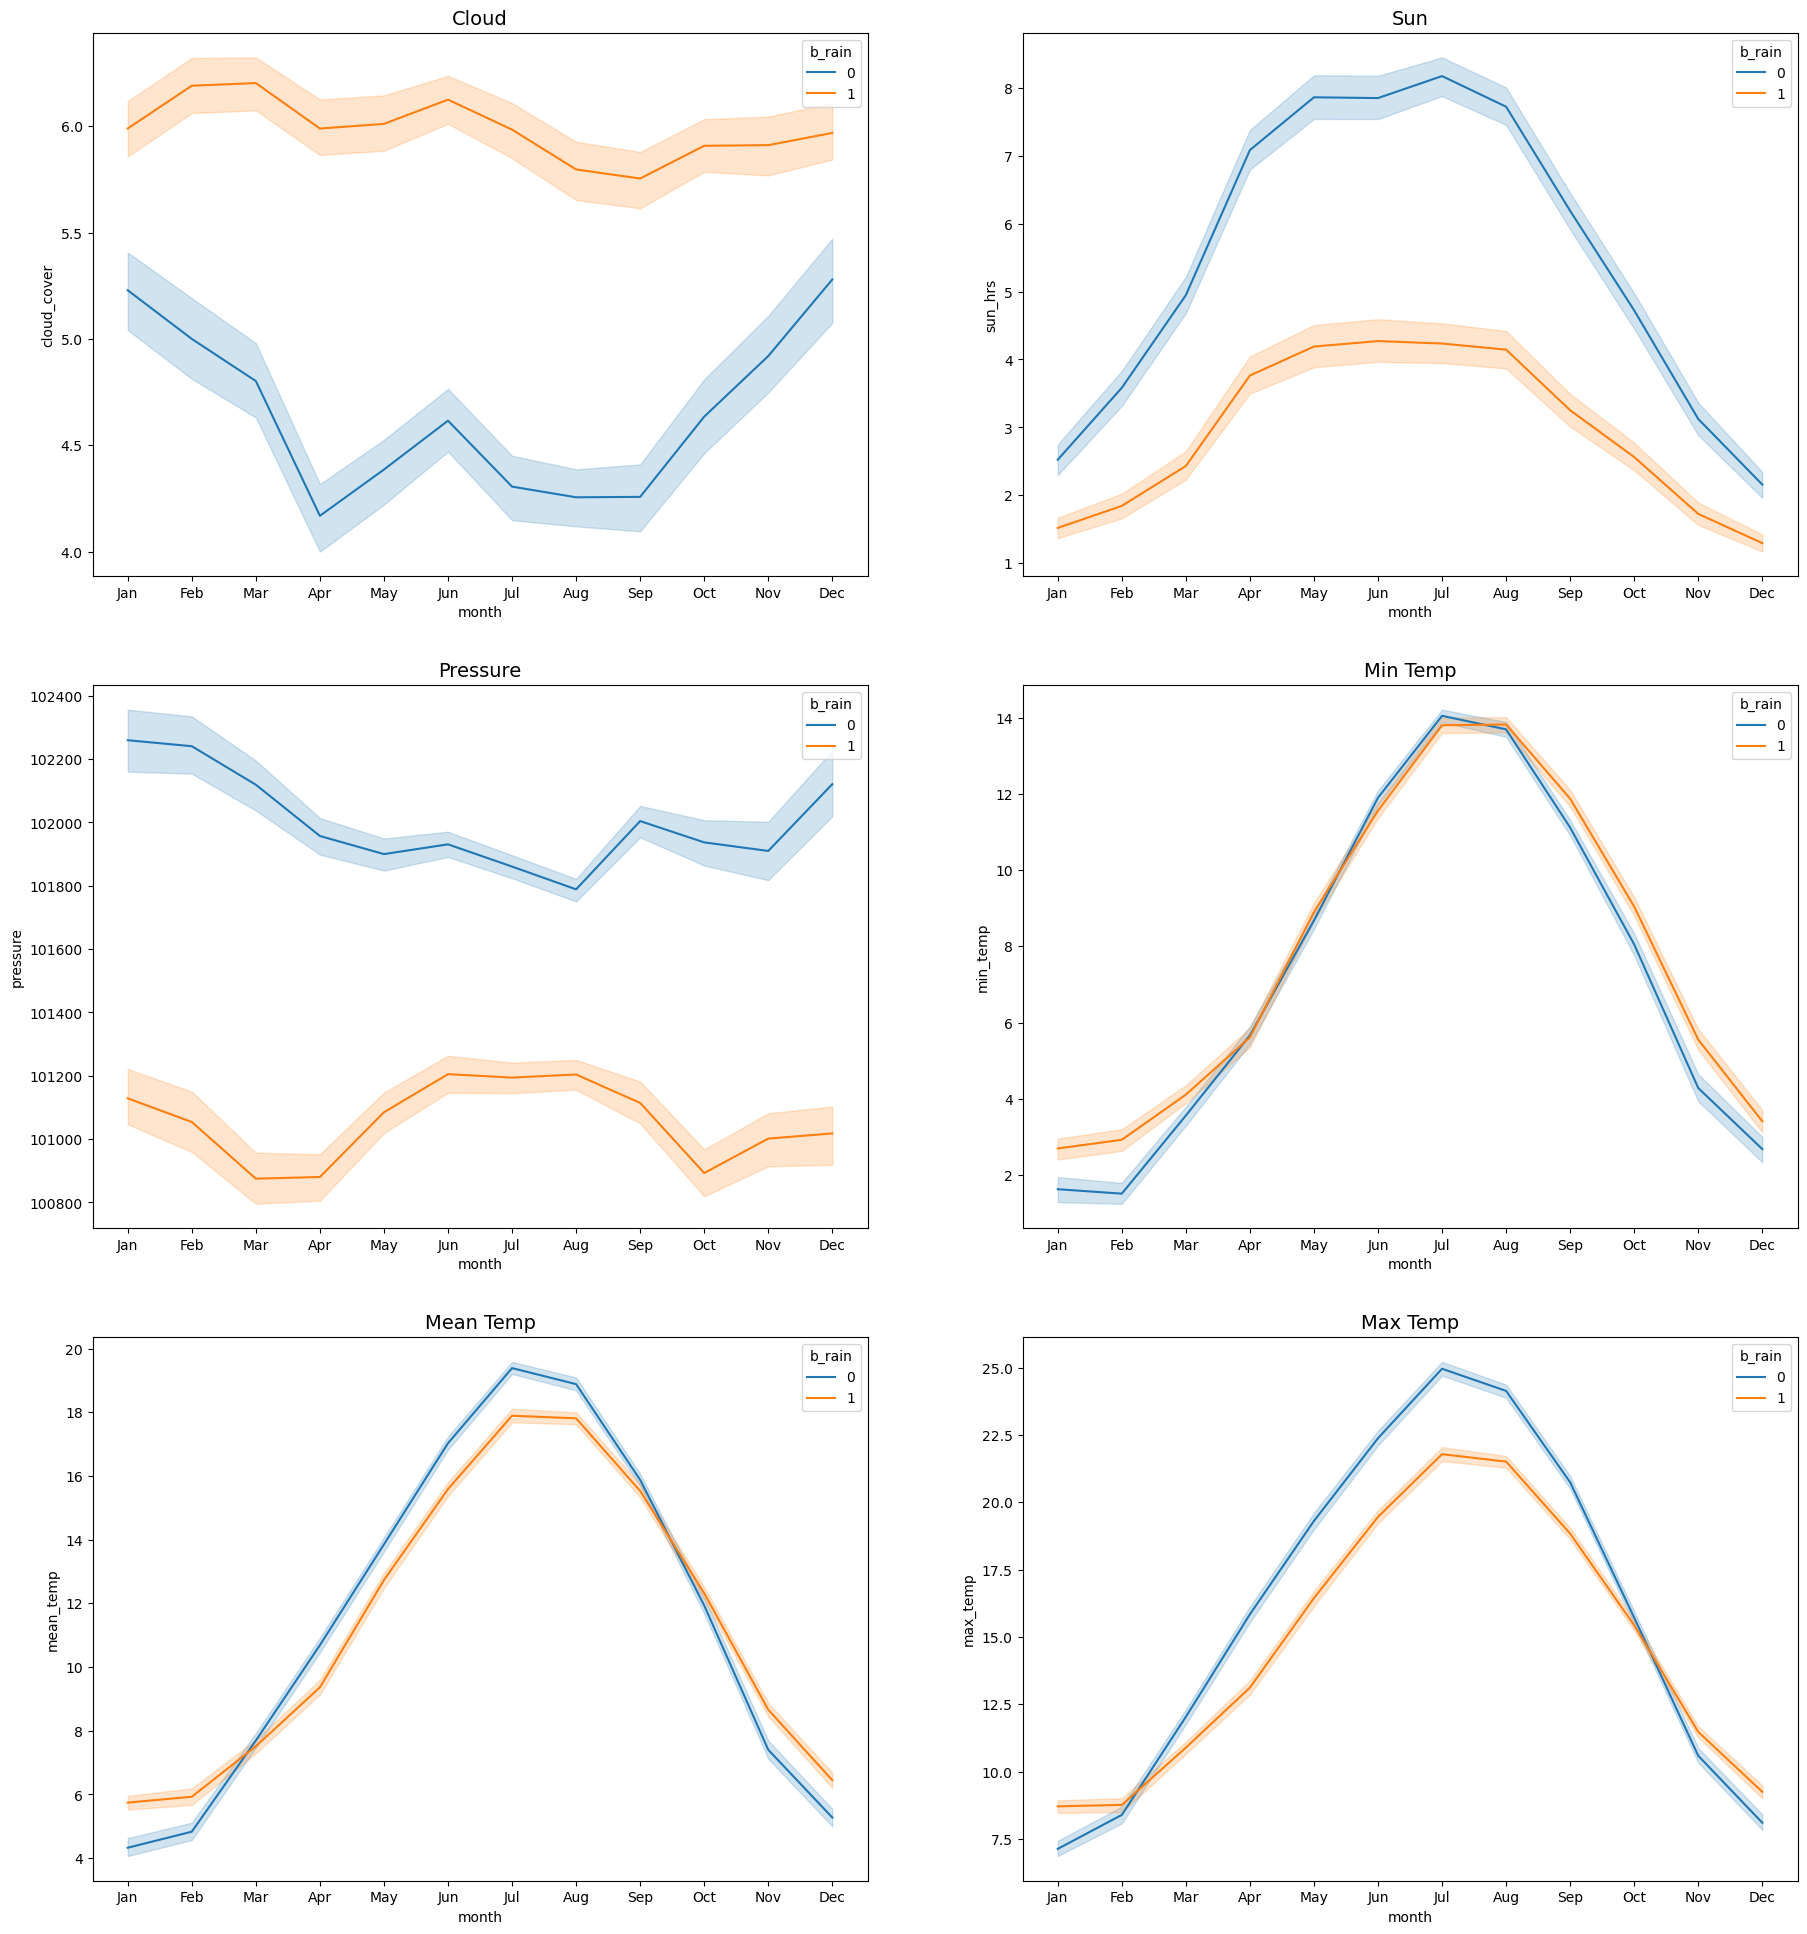

In [53]:
#Create line graphs depicting activity during each month
fig, ax = plt.subplots(3,2, figsize= (22,24))

sns.lineplot(data=df3, x='month', y='cloud_cover', hue='b_rain', ax=ax[0,0])
ax[0,0].set_title('Cloud', fontsize=14)

sns.lineplot(data=df3, x='month', y='sun_hrs', hue='b_rain', ax=ax[0,1])
ax[0,1].set_title('Sun', fontsize=14)

sns.lineplot(data=df3, x='month', y='pressure', hue='b_rain', ax=ax[1,0])
ax[1,0].set_title('Pressure', fontsize=14)

sns.lineplot(data=df3, x='month', y='min_temp', hue='b_rain', ax=ax[1,1])
ax[1,1].set_title('Min Temp', fontsize=14)

sns.lineplot(data=df3, x='month', y='mean_temp', hue='b_rain', ax=ax[2,0])
ax[2,0].set_title('Mean Temp', fontsize=14)

sns.lineplot(data=df3, x='month', y='max_temp', hue='b_rain', ax=ax[2,1])
ax[2,1].set_title('Max Temp', fontsize=14)

With these line graphs we can see that certain features have a clearer indication if rain will occur or not. The big takeaway here is how the time of year plays into these relationships. With The mean and max temp, we see that during the summer months, there is a greater separation when it rains or not. From March to roughly September, it suggests that rain has some influence on mean temp, a larger influence on max temp, and interestingly very little influence on min temp. - As for the other features, cloud cover, sun hours, and pressure, we can see a clear split consistently throughout the year. In some areas this can get really close however. - It seems that no rain means that there is a higher chance that cloud cover is lower while sun hours and pressure are higher. 

C:\Users\Phill\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Phill\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Phill\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Phill\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a len

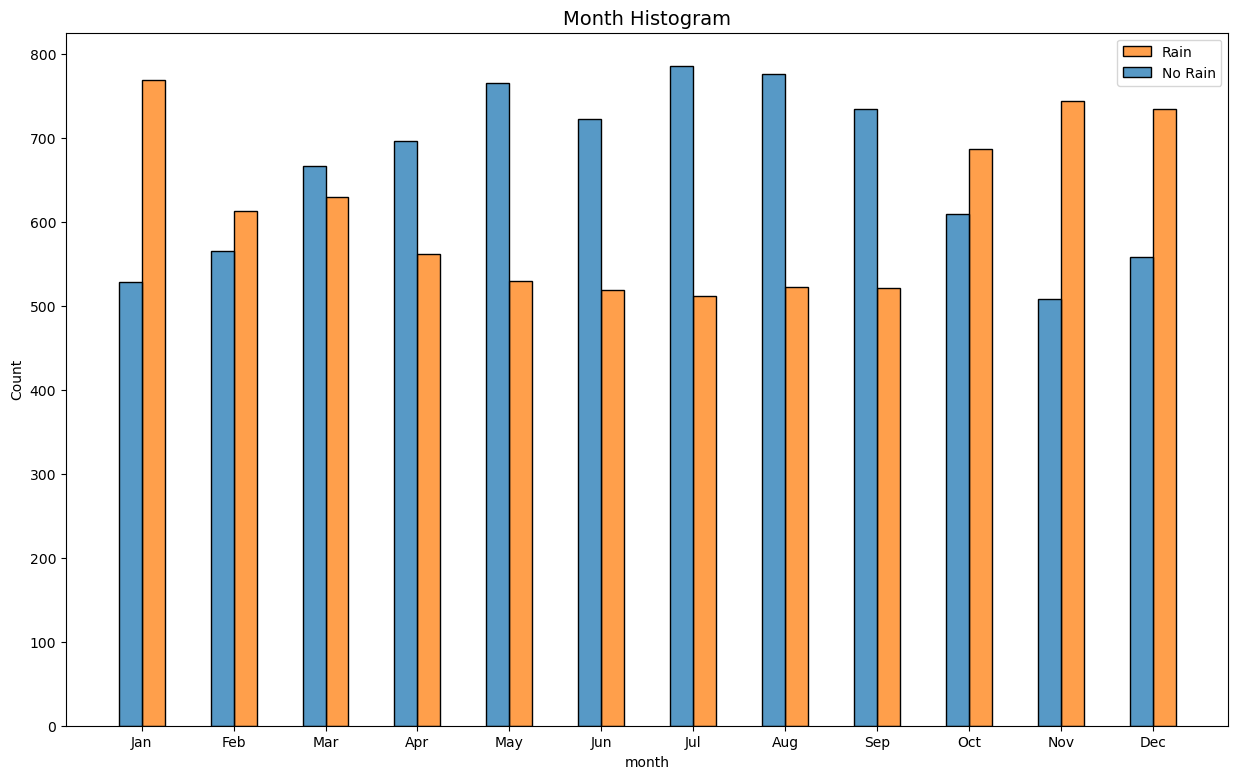

In [54]:
#create histplot of month, comparing days that rained and those that didn't 

plt.figure(figsize=(15,9))
sns.histplot(data=df3, x='month', hue='b_rain', multiple='dodge', discrete=1, shrink=0.5)
plt.legend(labels=['Rain', 'No Rain'])
plt.title('Month Histogram', fontsize='14')
plt.show();

It appears that it rains more days than not from October to February, with the opposite being true between March and September. It appears to be a gradual shift with the seasons. More rainy days in Fall and Winter, more sunny days in Spring and Summer. 

### Get Dummies for Month column

In [55]:
#dummy encode the 'Month' column
df_enc = df3.copy()

df_enc = pd.get_dummies(df_enc, drop_first=False)
df_enc.head()

,cloud_cover,sun_hrs,radiation,max_temp,mean_temp,min_temp,pressure,b_rain,month_Apr,month_Aug,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep
0,2.0,7.0,52.0,2.3,-4.1,-7.5,101900.0,1,False,False,False,False,True,False,False,False,False,False,False,False
1,6.0,1.7,27.0,1.6,-2.6,-7.5,102530.0,0,False,False,False,False,True,False,False,False,False,False,False,False
2,5.0,0.0,13.0,1.3,-2.8,-7.2,102050.0,0,False,False,False,False,True,False,False,False,False,False,False,False
3,8.0,0.0,13.0,-0.3,-2.6,-6.5,100840.0,0,False,False,False,False,True,False,False,False,False,False,False,False
4,6.0,2.0,29.0,5.6,-0.8,-1.4,102250.0,0,False,False,False,False,True,False,False,False,False,False,False,False


### Split Data into Train, Validate, and Test Sets

In [56]:
#Seperate X variables 
X = df_enc.drop(columns=['b_rain'])

#Isolate y variable 
y = df_enc['b_rain']

In [57]:
#Split into train and test sets 
X_tr, X_test, y_tr, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)

#Split into train and validate sets 
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, stratify=y_tr, test_size=0.25, random_state=1)

In [58]:
#Ensure split ratio
for x in [X_train, X_val, X_test]:
    print(len(x))
    

9156
3052
3053


# Modeling

### First: Random Forest

In [59]:
#Instantiate random forest classifier
rf = RandomForestClassifier(random_state=1)

#Create dictionary of hyperparameters to tune
cv_params = {'max_depth': [4,6,8], 
             'max_features': [1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [100,150,200],
             }  

#Assign a dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

#Instantiate GridSearch
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [60]:
%%time
rf_cv.fit(X_train, y_train)

CPU times: total: 13min 20s
Wall time: 13min 22s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=1),
             param_grid={'max_depth': [4, 6, 8], 'max_features': [1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [100, 150, 200]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [61]:
#pickle the model
with open('rf_cv_model.pickle', 'wb') as to_write:
    pickle.dump(rf_cv, to_write)

In [62]:
#read pickled model
with open('rf_cv_model.pickle', 'rb') as to_read:
    rf_cv = pickle.load(to_read)

In [63]:
#Check best AUC score of model
rf_cv.best_score_

0.8283755258695031

In [64]:
#Check best parameters
rf_cv.best_params_

{'max_depth': 6,
 'max_features': 1.0,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 150}

In [65]:
#Create function to extract model scores - adjusted from Google Adanced Data Analytics Course 

def get_results(model_name:str, model, metric:str):
    
    metric_dict = {'auc': 'mean_test_roc_auc',
                   'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy'
                  }

    cv_results = pd.DataFrame(model.cv_results_)
    
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]
    
    roc_auc = best_estimator_results.mean_test_roc_auc
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    table = pd.DataFrame()
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          'auc': [roc_auc]
                         })
    
    return table 

In [66]:
#Get results
rf_cv_results = get_results('Random Forest', rf_cv, 'auc')
rf_cv_results

,model,precision,recall,F1,accuracy,auc
0,Random Forest,0.738653,0.735813,0.737084,0.747379,0.828376


This random forests model seems to have promising, but not stellar, scores, with 74.74% accuracy and 82.84% AUC. 

### Second: XGBoost Model

In [67]:
#Instantiate XGBoost Classifier 
xgb = XGBClassifier(objective='binary:logistic', random_state=1)

#Create dictionary of hyperparameters to tune
cv_params = {'max_depth': [4, 6, 8],
             'min_child_weight': [1,2,4],
             'learning_rate': [0.01, 0.05, 0.1],
             'n_estimators': [100, 150, 200],
             }

#Assign a dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

#Instantiate GridSearch
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [68]:
%%time
xgb_cv.fit(X_train, y_train)

CPU times: total: 5min 1s
Wall time: 39.1 s


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=1, ...),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [4, 6, 8], 'min_child_weight': [1, 2, 4],
                         'n_estimators': [100, 150, 200]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [69]:
#pickle the model
with open('xgb_cv_model.pickle', 'wb') as to_write:
    pickle.dump(xgb_cv, to_write)

In [70]:
#read pickled model
with open('xgb_cv_model.pickle', 'rb') as to_read:
    xgb_cv = pickle.load(to_read)

In [71]:
#Check best AUC score of model
xgb_cv.best_score_

0.8321152246403927

In [72]:
#Check best parameters
xgb_cv.best_params_

{'learning_rate': 0.05,
 'max_depth': 4,
 'min_child_weight': 4,
 'n_estimators': 200}

In [73]:
#Get results
xgb_cv_results = get_results('XGBoost', xgb_cv, 'auc')
xgb_cv_results

,model,precision,recall,F1,accuracy,auc
0,XGBoost,0.738112,0.743757,0.740819,0.749563,0.832115


In [74]:
#concat results to a table 
results_table = pd.concat([rf_cv_results, xgb_cv_results], axis=0)
results_table

,model,precision,recall,F1,accuracy,auc
0,Random Forest,0.738653,0.735813,0.737084,0.747379,0.828376
0,XGBoost,0.738112,0.743757,0.740819,0.749563,0.832115


This XGBoost model has an accuracy score of 74.96% and an AUC of 83.21%.

Given both models, we see that they have fairly similar scores with the XGBoost model just edging out the Random Forest Model in every metric except precision. These scores are not bad and appear to have fairly good predictive power. 

With this we will now test these models on our validation data to see which performs better given new entries. 

# Model Selection

In [75]:
#use random forest model to predict on validation set
rf_val_preds = rf_cv.best_estimator_.predict(X_val)

In [76]:
#create function to get scores of predicted values

def get_scores(model_name:str, preds, y_test_data):
    
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)
    auc = roc_auc_score(y_test_data, preds)
    
    table = pd.DataFrame({'model': [model_name],
                          'accuracy': [accuracy],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'auc': [auc]
                         })
    
    return table

In [77]:
#get RF scores from validation set
rf_val_scores = get_scores('RF Val', rf_val_preds, y_val)

#Add to results table
results_table = pd.concat([results_table, rf_val_scores], axis=0)
results_table

,model,precision,recall,F1,accuracy,auc
0,Random Forest,0.738653,0.735813,0.737084,0.747379,0.828376
0,XGBoost,0.738112,0.743757,0.740819,0.749563,0.832115
0,RF Val,0.735294,0.714772,0.724888,0.738860,0.737992


In [78]:
#use XGBoost model to predict on validation set
xgb_val_preds = xgb_cv.best_estimator_.predict(X_val)

#get XGB scores from validation set
xgb_val_scores = get_scores('XGB Val', xgb_val_preds, y_val)

#add scores to results table
results_table = pd.concat([results_table, xgb_val_scores], axis=0)
results_table

,model,precision,recall,F1,accuracy,auc
0,Random Forest,0.738653,0.735813,0.737084,0.747379,0.828376
0,XGBoost,0.738112,0.743757,0.740819,0.749563,0.832115
0,RF Val,0.735294,0.714772,0.724888,0.738860,0.737992
0,XGB Val,0.733010,0.719537,0.726211,0.738860,0.738164


The results on the validation set are extremely close with noticeably lower auc scores. Once more, though just barely, the XGB model outdid the random forest model in all scores excelpt precision. 

Given this, there isn't a clear winner when it comes to performace, as it is possible that either could do better with the final test set. The big difference however is the time that each model takes to process. The XGBoost model was several times faster so this is the one we will continue to work with moving forward. 

# Use XGBoost model to predict on test set

In [79]:
#use XGBoost model to predict on test set
xgb_test_preds = xgb_cv.best_estimator_.predict(X_test)

#get XGB scores from test set
xgb_test_scores = get_scores('XGB Test', xgb_test_preds, y_test)

#add scores to results table
results_table = pd.concat([results_table, xgb_test_scores], axis=0)
results_table

,model,precision,recall,F1,accuracy,auc
0,Random Forest,0.738653,0.735813,0.737084,0.747379,0.828376
0,XGBoost,0.738112,0.743757,0.740819,0.749563,0.832115
0,RF Val,0.735294,0.714772,0.724888,0.738860,0.737992
0,XGB Val,0.733010,0.719537,0.726211,0.738860,0.738164
0,XGB Test,0.735875,0.735875,0.735875,0.745824,0.745463


The scores on the test set are all slightly higher than those of the validation set from either model. This is a good sign that the model does well with new/unseen data and is not overfit to the training data. 

### Confusion Matrix

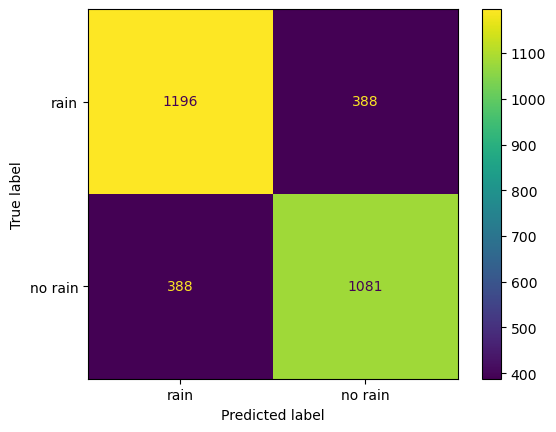

In [80]:
#generate array of values for confusion matrix
cm = confusion_matrix(y_test, xgb_test_preds, labels=xgb_cv.classes_)

#plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['rain', 'no rain'])

disp.plot();

The model predicts false positives and false negatives equally (given this set of data). Given an accuracy of 74.58%, this means that of the 25.42% of inaccuracte predictions, it is equally likely to be a false negative or false positive. The model does not seem to misjudge one or the other more frequently. 

To explore further, we will look at the important features in the model. 

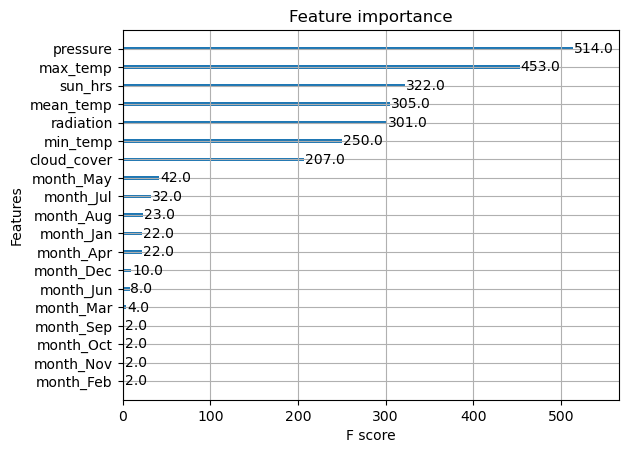

In [81]:
#use plot importance function
plot_importance(xgb_cv.best_estimator_);

## Evaluation / Summary

**Model Performance**

Between the two models, the XGBoost slightly out performed Random Forests with AUC of 74.54%, precision of 73.59%, recall of 73.59%, f1 score of 73.59%, and accuracy of 74.58% on the test data.

**Feature Importance**

Prior to EDA, it was thought that sun_hrs and cloud_cover would be big factors in determing if it would rain or not. Within EDA, we found some evidence to suggest this as they were the second and third most correlated feature to b_rain, behind pressure. Looking over the feature importances, it shows that pressure, max_temp, and sun_hrs are the most influential features in the model. - As for the months, we do find three summer months (May, July, August) at the top and three fall/winter months at the bottom (October, November, February). 

**Takeaways**

This model does a fairly good job at predicting if it rained or not on a given day in London, as was the goal of the project. I now have a model that will prepare me for the weather during my upcoming August trip, allowing for proper dress, preventing a bad hair day, and the packing of an umbrella on needed days. Now, you may be wondering the usefulness of this model beyond such a scope, but that was not the point. As this is my first project I wanted to make sure that my approach, implementations, and steps were sound. However, I do believe that this data could be paired with other date specific datasets like vehicle accidents or tube use to generate more applicable predictive models. I do also believe that this model in particular could be improved through the use of some feature engineering (i.e. day-temp range) and the introduction of other weather related metrics such as wind-speed and humidity. 